In [2]:
import shlex
from tqdm import tqdm
from IPython.display import display

from GTTA import config_summoner
from GTTA.kernel.main import initialize_model_dataset
from GTTA.utils.args import args_parser
from GTTA.utils.load_manager import load_atta_algorithm, load_alg
from GTTA.utils.load_manager import load_tta_algorithm
from GTTA.utils.logger import load_logger

argv = shlex.split('--task train --config_path TTA_configs/PACS/base.yaml --gpu_idx 2 --exp_round 1')
print(argv)
args = args_parser(argv)
config = config_summoner(args)
# load_logger(config)

alg = load_atta_algorithm(config)

from pathlib import Path
save_path = Path(config.ckpt_dir) / 'exp'
save_path.mkdir(parents=True, exist_ok=True) 
# alg()

['--task', 'train', '--config_path', 'TTA_configs/PACS/base.yaml', '--gpu_idx', '2', '--exp_round', '1']


In [3]:
from tqdm.notebook import tqdm
import time
for i in tqdm(range(100)):
    print(1)
    time.sleep(1)

  0%|          | 0/100 [00:00<?, ?it/s]

1
1
1
1
1
1
1
1


KeyboardInterrupt: 

In [2]:
import random

import numpy as np
import torch

def reset_random_seed(seed):
    # Fix Random seed
    random.seed(config.random_seed)
    np.random.seed(config.random_seed)
    torch.manual_seed(config.random_seed)
    torch.cuda.manual_seed(config.random_seed)
    torch.cuda.manual_seed_all(config.random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

$\mathcal{D}$: joint distribution - $P(X, Y)$

$\mathcal{X}$ input space. random variable $X$ on the $\mathcal{X}$ with probability $P(X)$.
$\hat{Y}\sim P_\phi(Y|X)$

$\mathcal{D}_{\phi, \mathcal{S}} = P_\phi(Y|X)P_\mathcal{S}(X)$

# Storyline

Test-time adaptation task can be considered as **multiple domain adaptation tasks**, where source domain expands while new target domain streaming in continuously. Initially, before the test phase begins, we have the initial training set $\mathcal{D}_S(0)$. At time $t = 1$, the training and test data are defined as $\mathcal{D}_S(1) = {\mathcal{D}_S(0)}$ and $\mathcal{D}_T(1)$. For every time point $t$, given that $\mathcal{U}_T(t_i) \subseteq \mathcal{D}_T(t_i)$, the training and test data can be expressed as
$$\mathcal{D}_S(t)=\{\mathcal{D}_S(0),\mathcal{U}_T(1),\mathcal{U}_T(2),\cdots,\mathcal{U}_T(t-1)\}\text{ and } \mathcal{D}_T(t).$$
The subset $\mathcal{U}_T(t-1)$ is actively labeled before each time period $t$ starts.

Therefore, at the time frame $t$, we are intrinsically considering a domain adaptation problem where the source domain is $\mathcal{D}_S(t)$ and the target domain is $\mathcal{D}_T(t)$. 

For simplicity, we consider a domain adaptation problem where we have a source domain $D_\mathcal{S}$ and a target domain $D_\mathcal{T}$. The learning theory indicates that the empirical target domain performance (error) $\epsilon_T$ is mainly bounded by two parts:

* The learning deviation between empirical errors and true errors: $|\epsilon^S(h) - \hat{\epsilon}^S(h)|$ and $|\epsilon^T(h) - \hat{\epsilon}^T(h)|$. This term is denoted as $B$.
* The divergence between $D_\mathcal{S}$ and $D_\mathcal{T}$. We denote this term as $A \in [0, 1]$

## Experiment of empirical target error with different $\alpha$ and $\beta$
* $\alpha$: learning weights - $\mathcal{L} = (1 - \alpha) * \mathcal{L}_\mathcal{S} + \alpha * \mathcal{L}_\mathcal{T}$
* $\beta$: number of samples weights - $\mathcal{D} = \mathcal{D}_\mathcal{S}.sample((1 - \beta) * m) + \mathcal{D}_\mathcal{T}.sample(\beta * m)$. $m$ is the total sample number of the dataset $D$.

Given $\beta$, when the VC-dimension $d$ is much larger than $A$, we can prove that this bound is dominated by $B$. Because $B$ reaches its optimum when $\alpha=\beta$, we conduct the following experiments to illustrate the consistency between the theory and the practice.

In the following first experiment, we train models using $m=2000$ samples with different $\alpha$ and $\beta$, and test these models on the target domain. We draw the target domain loss surface as following. According to the alignment between the $\alpha=\beta$ line and the loss minimums, we can conclude that **1) the VC-dimension $d$ is indeed much larger than $A$, 2) the theoretical bound is practical.**

In [3]:
# Prepare for training
import numpy as np
D_S = alg.dataset[0]
D_T = alg.target_dataset

In [4]:
import torch
import torch.nn as nn
import copy
from tqdm import tqdm_notebook
from torch.utils.data import ConcatDataset
from GTTA.data.good_loaders.fast_data_loader import InfiniteDataLoader, FastDataLoader
from GTTA.utils.register import register
import pandas as pd

def train_new_model(alpha, beta, device, m=2000, tol = 1e-3, source_trained=False):
    S_choice = np.random.choice(len(D_S), int((1 - beta) * m), replace=False)
    T_choice = np.random.choice(len(D_T), int(beta * m), replace=False)
    D_S_loader = InfiniteDataLoader(D_S,  
                                    weights=None,
                                    batch_size=config.train.train_bs,
                                    num_workers=config.num_workers, 
                                    subset=S_choice)

    D_T_loader = InfiniteDataLoader(D_T,  
                                    weights=None,
                                    batch_size=config.train.train_bs,
                                    num_workers=config.num_workers, 
                                    subset=T_choice)

    if source_trained:
        model = copy.deepcopy(alg.model.cpu()).to(device)
    else:
        encoder = register.models[config.model.name](config)
        model = nn.Sequential(encoder, 
                              nn.Linear(encoder.n_outputs, config.dataset.num_classes)).to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    lowest_loss = float('inf')
    stop_count = 0
    DT_loader = iter(zip(D_S_loader, D_T_loader))
    epoch_pbar = tqdm_notebook(range(100))
    for epoch in epoch_pbar:
        mean_loss = []
        for _ in range(100):
            # display(f'{i}')
            S_d, T_d = next(DT_loader)
            S_data, S_targets = S_d[0].to(device), S_d[1].to(device)
            T_data, T_targets = T_d[0].to(device), T_d[1].to(device)
            L_S = config.metric.loss_func(model(S_data), S_targets)
            L_T = config.metric.loss_func(model(T_data), T_targets)
            loss = (1 - alpha) * L_S + alpha * L_T
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            mean_loss.append(loss.item())
        mean_loss = np.mean(mean_loss)
        epoch_pbar.set_description(f'ML: {mean_loss:.6f}')

        stop_count += 1
        if mean_loss < lowest_loss:
            stop_count = 0
            lowest_loss = mean_loss
        if stop_count >= 5 or mean_loss < tol:
            break
    return model

@torch.no_grad()
def test_on_env(model, loader, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += config.metric.loss_func(output, target, reduction='sum').item()
        test_acc += config.metric.score_func(target, output) * len(data)
    test_loss /= len(loader.sampler)
    test_acc /= len(loader.sampler)
    return test_loss, test_acc

def save_exp(Z, filename):
    Z.to_csv(save_path / filename)

def load_exp(filename):
    Z = pd.read_csv(save_path / filename, index_col=[0, 1], header=0)
    Z.columns = np.round(Z.columns.astype(float), 2)
    return Z

In [5]:
from tqdm.notebook import tqdm

reset_random_seed(520)

Full_D_S_loader = FastDataLoader(D_S,  
                            weights=None,
                            batch_size=config.train.train_bs,
                            num_workers=config.num_workers)
Full_D_T_loader = FastDataLoader(D_T,  
                            weights=None,
                            batch_size=config.train.train_bs,
                            num_workers=config.num_workers)

alpha = np.concatenate([np.arange(0, 0.29, 0.05), np.arange(0.4, 1.1, 0.2)]).round(2)
beta = np.arange(0, 0.29, 0.05).clip(0.001, 0.999).round(3)
m = 2000
exp1_Z = pd.concat([pd.DataFrame(index=beta, columns=alpha, dtype=float) for _ in range(4)], 
                          keys=['loss_S', 'loss_T', 'acc_S', 'acc_T'])

never_source = True
device = config.device

dh = display(exp1_Z, display_id=True)

train_pbar = tqdm(exp1_Z.loc['loss_S'].unstack(-1).index)
for al, be in train_pbar:
    model = train_new_model(alpha=al, beta=be, device=device, m=m, source_trained=False)
    test_loss_S, test_acc_S = test_on_env(model, Full_D_S_loader, device=device)
    test_loss_T, test_acc_T = test_on_env(model, Full_D_T_loader, device=device)
    
    exp1_Z.loc[(slice(None), be), al] = test_loss_S, test_loss_T, test_acc_S, test_acc_T
    train_pbar.set_description(f'Source L/A: {test_loss_S:.4f}/{test_acc_S:.4f}, Target L/A: {test_loss_T:.4f}/{test_acc_T:.4f}')
    dh.update(exp1_Z)


0.00      0.05      0.10      0.15      0.20      0.25  \
loss_S 0.001  0.006263  0.007063  0.008287  0.000638  0.005833  0.005680   
       0.050  0.022557  0.013471  0.015489  0.016648  0.011388  0.019958   
       0.100  0.036507  0.033268  0.036507  0.020938  0.017298  0.022409   
       0.150  0.032388  0.038281  0.058588  0.031888  0.028016  0.043919   
       0.200  0.042967  0.050972  0.047362  0.050550  0.057548  0.034873   
       0.250  0.080130  0.063128  0.057424  0.066384  0.070135  0.054879   
loss_T 0.001  1.283454  1.820528  1.482696  2.972042  1.720131  2.193962   
       0.050  1.314331  0.620749  0.923013  0.861736  0.716508  0.919030   
       0.100  1.361601  0.554408  0.661989  0.595763  0.664227  0.611826   
       0.150  1.210669  0.530829  0.583085  0.451819  0.499981  0.495372   
       0.200  1.288027  0.514829  0.434140  0.465689  0.476383  0.402468   
       0.250  1.582741  0.479030  0.427671  0.422874  0.442446  0.468431   
acc_S  0.001  0.997559  0.997559  0.998047  1.000000  0.998047  0.998535   
       0.050  0.995117  0.995605  0.996582  0.993652  0.996582  0.994629   
       0.100  0.988281  0.990723  0.990723  0.993164  0.993164  0.994141   
       0.150  0.990234  0.991211  0.986328  0.992188  0.989746  0.989258   
       0.200  0.985840  0.985352  0.984375  0.984375  0.985840  0.988770   
       0.250  0.980469  0.981934  0.985840  0.983887  0.982910  0.981934   
acc_T  0.001  0.711693  0.670352  0.721548  0.602692  0.637664  0.630093   
       0.050  0.699676  0.828867  0.795097  0.797380  0.839683  0.803028   
       0.100  0.691383  0.849417  0.833794  0.850138  0.845451  0.850499   
       0.150  0.699676  0.852782  0.860594  0.880663  0.878380  0.875015   
       0.200  0.684173  0.865401  0.875736  0.870328  0.877419  0.884028   
       0.250  0.673116  0.871770  0.880663  0.881985  0.887393  0.880543   

                  0.40      0.60      0.80       1.00  
loss_S 0.001  0.003854  0.011253  0.004942  16.924438  
       0.050  0.015129  0.014956  0.011657   1.622296  
       0.100  0.031447  0.026883  0.045238   1.101960  
       0.150  0.028881  0.051967  0.067644   0.713955  
       0.200  0.031355  0.071653  0.059883   0.630875  
       0.250  0.062902  0.085325  0.086635   0.697948  
loss_T 0.001  1.489847  2.928639  2.104620  20.110625  
       0.050  0.806016  0.691924  0.818460   1.234782  
       0.100  0.624794  0.665488  0.692027   0.943018  
       0.150  0.452813  0.652483  0.505445   0.661528  
       0.200  0.538914  0.565634  0.556562   0.687833  
       0.250  0.419113  0.513980  0.509094   0.612434  
acc_S  0.001  0.998535  0.997070  0.999512   0.139160  
       0.050  0.995117  0.995117  0.996094   0.592285  
       0.100  0.990723  0.990723  0.990234   0.673340  
       0.150  0.991699  0.986816  0.979492   0.802734  
       0.200  0.988281  0.979004  0.983398   0.819336  
       0.250  0.981934  0.975586  0.978027   0.802246  
acc_T  0.001  0.677322  0.610864  0.576133   0.166326  
       0.050  0.820815  0.824420  0.802908   0.654248  
       0.100  0.852662  0.844610  0.841245   0.736089  
       0.150  0.879942  0.854585  0.873573   0.808677  
       0.200  0.880663  0.872131  0.872491   0.823939  
       0.250  0.892681  0.883427  0.890638   0.841485

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
from tqdm.notebook import tqdm
import time
for i in tqdm(range(100)):
    print(1)
    time.sleep(1)

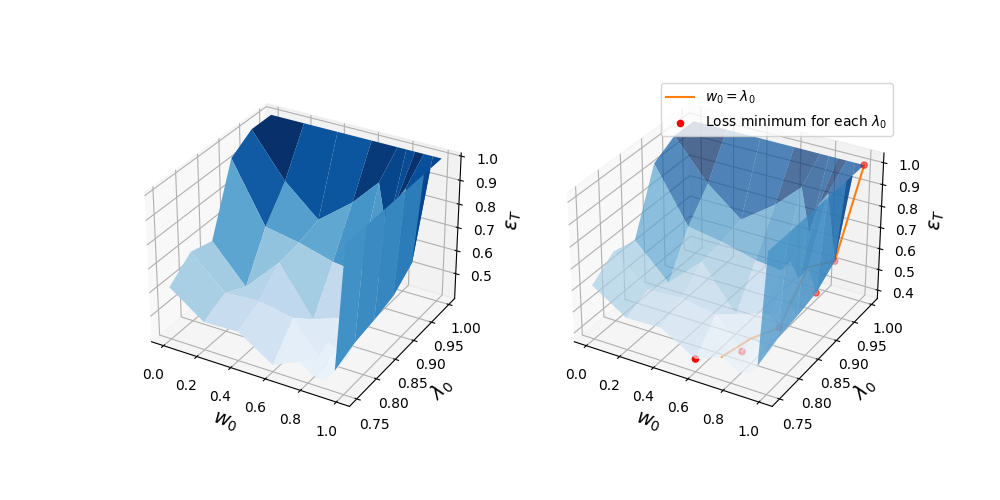

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib

# matplotlib.get_backend()
# matplotlib.use('TkAgg')

from matplotlib.backend_bases import MouseButton
import traceback
exp1_Z = load_exp('exp1.csv')
Z = exp1_Z.loc['loss_T'].clip(0, 1)
Z.columns = 1 - Z.columns
Z.index = 1 - Z.index
Z_np = Z.to_numpy()

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 5))

ax[1].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=0.7)
ax[1].plot(Z.columns[:len(Z.index)], Z.index, Z.unstack().loc[list(zip(Z.columns[:len(Z.index)], Z.index))], zdir='z', label=r'$w_0=\lambda_0$')
ax[1].scatter(Z.idxmin(1),
           Z.index,
           Z.min(1).values,
           c='red', label=r'Loss minimum for each $\lambda_0$')

# ax.set(xticklabels=[],
#        yticklabels=[],
#        zticklabels=[])

for ax_i in ax:
    ax_i.set_xlabel(r'$w_0$', size=14)
    ax_i.set_ylabel(r'$\lambda_0$', size=14)
    ax_i.set_zlabel(r'$\epsilon_T$', size=14)
ax[1].legend(loc=1)
# ax[1].set_title("Target loss surface")

ax[0].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=1)

error_log = []

def on_move(event):
    try:
        if event.button == MouseButton.LEFT and event.inaxes in ax:
            # Get current rotation
            curr_elev, curr_azim = event.inaxes.elev, event.inaxes.azim
            
            # Calculate the new rotation angles based on mouse movement
            # log.append(f'{event.ydata}')
            new_elev = curr_elev - event.ydata + event.lastevent.ydata
            new_azim = curr_azim - event.xdata + event.lastevent.xdata
            # log.append(f'{new_elev}, {new_azim}')

            # Update the rotation for both axes and redraw
            for ax_i in ax:
                ax_i.view_init(elev=new_elev, azim=new_azim)
                ax_i.figure.canvas.draw_idle()
    except Exception as e:
        traceback.print_exc()
        error_log.append(f'{traceback.format_exc()}')
        

cid = fig.canvas.mpl_connect('motion_notify_event', on_move)
# fig.suptitle('Target loss surface [m=2000 no-S-pretrain]', fontsize=16)

# ax[0].set_zlim(Z_np.min(), 5)
plt.show()

In [7]:
# import matplotlib
%matplotlib widget
matplotlib.get_backend()

'module://ipympl.backend_nbagg'

  0%|          | 0/100 [00:00<?, ?it/s]

1
1
1
1
1
1
1
1
1
1


KeyboardInterrupt: 

In [8]:
# save_exp(exp1_Z, 'exp1.csv')

## Experiment 2: Source pre-trained model with $\alpha$ and $\beta$ changed.

In [9]:
from tqdm.notebook import tqdm

reset_random_seed(520)

Full_D_S_loader = FastDataLoader(D_S,  
                            weights=None,
                            batch_size=config.train.train_bs,
                            num_workers=config.num_workers)
Full_D_T_loader = FastDataLoader(D_T,  
                            weights=None,
                            batch_size=config.train.train_bs,
                            num_workers=config.num_workers)

alpha = np.concatenate([np.arange(0, 0.29, 0.05), np.arange(0.4, 1.1, 0.2)]).round(2)
beta = np.arange(0, 0.29, 0.05).clip(0.001, 0.999).round(3)
m = 2000
exp2_Z = pd.concat([pd.DataFrame(index=beta, columns=alpha, dtype=float) for _ in range(4)], 
                          keys=['loss_S', 'loss_T', 'acc_S', 'acc_T'])

never_source = True
device = config.device

dh = display(exp2_Z, display_id=True)

train_pbar = tqdm(exp2_Z.loc['loss_S'].unstack(-1).index)
for al, be in train_pbar:
    model = train_new_model(alpha=al, beta=be, device=device, m=m, source_trained=True)
    test_loss_S, test_acc_S = test_on_env(model, Full_D_S_loader, device=device)
    test_loss_T, test_acc_T = test_on_env(model, Full_D_T_loader, device=device)
    
    exp2_Z.loc[(slice(None), be), al] = test_loss_S, test_loss_T, test_acc_S, test_acc_T
    train_pbar.set_description(f'Source L/A: {test_loss_S:.4f}/{test_acc_S:.4f}, Target L/A: {test_loss_T:.4f}/{test_acc_T:.4f}')
    # display(f'alpha/beta: {al}/{be}, Source L/A: {test_loss_S:.4f}/{test_acc_S:.4f}, Target L/A: {test_loss_T:.4f}/{test_acc_T:.4f}')
    dh.update(exp2_Z)

save_exp(exp2_Z, 'exp2.csv')

0.00      0.05      0.10      0.15      0.20      0.25  \
loss_S 0.001  0.014354  0.006697  0.007325  0.001039  0.004428  0.007485   
       0.050  0.025999  0.016118  0.016613  0.015782  0.010405  0.026494   
       0.100  0.039959  0.028040  0.031851  0.025729  0.029341  0.022180   
       0.150  0.049360  0.027000  0.055092  0.032141  0.026699  0.057841   
       0.200  0.045787  0.046667  0.066147  0.060767  0.075412  0.044574   
       0.250  0.078097  0.062516  0.072138  0.069328  0.072440  0.063797   
loss_T 0.001  1.515771  1.863035  1.523438  1.423199  1.594173  0.970797   
       0.050  1.432820  0.689407  0.641527  0.675643  0.603404  0.704246   
       0.100  2.269013  0.617931  0.621484  0.587992  0.710246  0.675543   
       0.150  1.255545  0.508166  0.603033  0.489330  0.574263  0.524293   
       0.200  1.222338  0.495670  0.485979  0.503320  0.491933  0.463383   
       0.250  1.743381  0.455814  0.475434  0.457392  0.473680  0.486311   
acc_S  0.001  0.996582  0.998047  0.999023  1.000000  0.998535  0.997559   
       0.050  0.993164  0.995117  0.995605  0.996094  0.997559  0.993164   
       0.100  0.988770  0.992188  0.991211  0.991699  0.990234  0.992676   
       0.150  0.989258  0.991211  0.985840  0.990234  0.992188  0.987793   
       0.200  0.989746  0.985352  0.982910  0.985352  0.980469  0.985352   
       0.250  0.980469  0.980957  0.984375  0.978027  0.979980  0.983398   
acc_T  0.001  0.721668  0.692224  0.751112  0.719865  0.724192  0.771782   
       0.050  0.717221  0.835957  0.846773  0.841005  0.870208  0.846653   
       0.100  0.679245  0.857469  0.851580  0.863117  0.855666  0.854825   
       0.150  0.762408  0.866362  0.864920  0.884269  0.878500  0.878861   
       0.200  0.767095  0.870809  0.875255  0.878861  0.878741  0.885951   
       0.250  0.704362  0.882827  0.878500  0.882346  0.887153  0.883307   

                  0.40      0.60      0.80       1.00  
loss_S 0.001  0.010054  0.012299  0.005307  42.939024  
       0.050  0.018781  0.010247  0.015385   0.850176  
       0.100  0.021514  0.048699  0.052961   0.912579  
       0.150  0.033594  0.061215  0.074743   0.727781  
       0.200  0.040069  0.082609  0.072929   0.630604  
       0.250  0.054683  0.087212  0.070559   0.531089  
loss_T 0.001  1.311779  1.590229  2.035239  44.483300  
       0.050  0.686196  0.655508  0.807705   0.862331  
       0.100  0.655114  0.626806  0.619736   0.803989  
       0.150  0.488418  0.543691  0.478520   0.637339  
       0.200  0.543316  0.490399  0.580471   0.647284  
       0.250  0.452935  0.468538  0.537368   0.523639  
acc_S  0.001  0.997559  0.998047  0.999023   0.139160  
       0.050  0.994629  0.996094  0.997070   0.750488  
       0.100  0.993164  0.986328  0.989746   0.783203  
       0.150  0.991699  0.985352  0.981445   0.815918  
       0.200  0.987793  0.981445  0.979004   0.845703  
       0.250  0.980957  0.977539  0.980957   0.857910  
acc_T  0.001  0.725634  0.717702  0.653527   0.166326  
       0.050  0.852662  0.854344  0.836678   0.770941  
       0.100  0.864439  0.864439  0.867684   0.800385  
       0.150  0.887393  0.876818  0.887754   0.831150  
       0.200  0.886672  0.888235  0.879462   0.848816  
       0.250  0.897128  0.888956  0.887874   0.865521

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

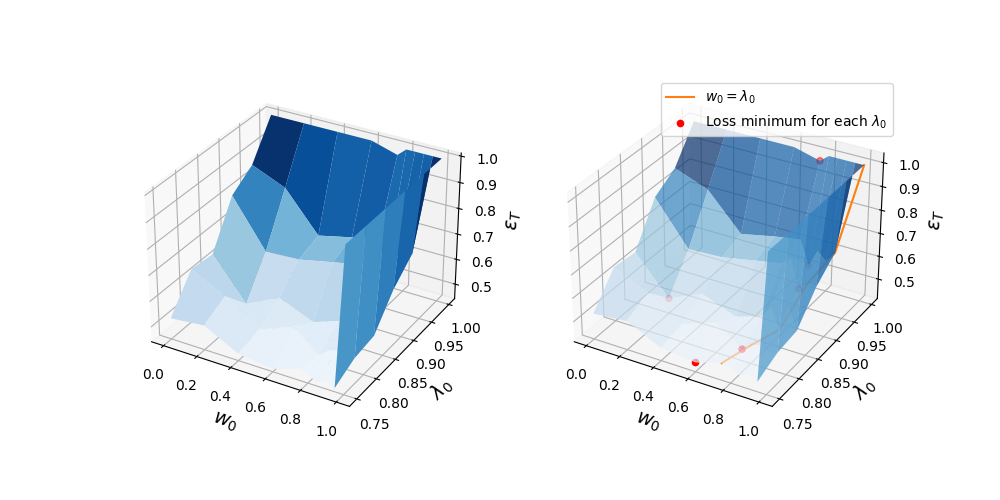

In [31]:
from matplotlib.backend_bases import MouseButton
import traceback

Z = exp2_Z.loc['loss_T'].clip(0, 1)
Z.columns = 1 - Z.columns
Z.index = 1 - Z.index
Z_np = Z.to_numpy()

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 5))

ax[1].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=0.7)
ax[1].plot(Z.columns[:len(Z.index)], Z.index, Z.unstack().loc[list(zip(Z.columns[:len(Z.index)], Z.index))], zdir='z', label=r'$w_0=\lambda_0$')
ax[1].scatter(Z.idxmin(1),
           Z.index,
           Z.min(1).values,
           c='red', label=r'Loss minimum for each $\lambda_0$')

# ax.set(xticklabels=[],
#        yticklabels=[],
#        zticklabels=[])

for ax_i in ax:
    ax_i.set_xlabel(r'$w_0$', size=14)
    ax_i.set_ylabel(r'$\lambda_0$', size=14)
    ax_i.set_zlabel(r'$\epsilon_T$', size=14)
ax[1].legend(loc=1)
# ax[1].set_title("Target loss surface")

ax[0].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=1)

error_log = []

def on_move(event):
    try:
        if event.button == MouseButton.LEFT and event.inaxes in ax:
            # Get current rotation
            curr_elev, curr_azim = event.inaxes.elev, event.inaxes.azim
            
            # Calculate the new rotation angles based on mouse movement
            # log.append(f'{event.ydata}')
            new_elev = curr_elev - event.ydata + event.lastevent.ydata
            new_azim = curr_azim - event.xdata + event.lastevent.xdata
            # log.append(f'{new_elev}, {new_azim}')

            # Update the rotation for both axes and redraw
            for ax_i in ax:
                ax_i.view_init(elev=new_elev, azim=new_azim)
                ax_i.figure.canvas.draw_idle()
    except Exception as e:
        traceback.print_exc()
        error_log.append(f'{traceback.format_exc()}')
        

cid = fig.canvas.mpl_connect('motion_notify_event', on_move)
# fig.suptitle('Target loss surface [m=2000 S-pretrain]', fontsize=16)

# ax[0].set_zlim(Z_np.min(), 5)
plt.show()

## Experiment3: No pretrained model with $m=500$ for different $\alpha$ and $\beta$

In [11]:
from tqdm.notebook import tqdm

reset_random_seed(520)

Full_D_S_loader = FastDataLoader(D_S,  
                            weights=None,
                            batch_size=config.train.train_bs,
                            num_workers=config.num_workers)
Full_D_T_loader = FastDataLoader(D_T,  
                            weights=None,
                            batch_size=config.train.train_bs,
                            num_workers=config.num_workers)

alpha = np.arange(0, 1.1, 0.2).round(2)
beta = np.arange(0, 1.1, 0.2).clip(0.002, 0.998).round(3)
m = 500
exp3_Z = pd.concat([pd.DataFrame(index=beta, columns=alpha, dtype=float) for _ in range(4)], 
                          keys=['loss_S', 'loss_T', 'acc_S', 'acc_T'])

never_source = True
device = config.device

dh = display(exp3_Z, display_id=True)

train_pbar = tqdm(exp3_Z.loc['loss_S'].unstack(-1).index)
for al, be in train_pbar:
    model = train_new_model(alpha=al, beta=be, device=device, m=m, source_trained=False)
    test_loss_S, test_acc_S = test_on_env(model, Full_D_S_loader, device=device)
    test_loss_T, test_acc_T = test_on_env(model, Full_D_T_loader, device=device)
    
    exp3_Z.loc[(slice(None), be), al] = test_loss_S, test_loss_T, test_acc_S, test_acc_T
    train_pbar.set_description(f'Source L/A: {test_loss_S:.4f}/{test_acc_S:.4f}, Target L/A: {test_loss_T:.4f}/{test_acc_T:.4f}')
    # display(f'alpha/beta: {al}/{be}, Source L/A: {test_loss_S:.4f}/{test_acc_S:.4f}, Target L/A: {test_loss_T:.4f}/{test_acc_T:.4f}')
    dh.update(exp3_Z)

save_exp(exp3_Z, 'exp3.csv')

0.0       0.2       0.4       0.6       0.8        1.0
loss_S 0.002   0.248466  0.272436  0.294789  0.382457  0.427176  17.561115
       0.200   0.310926  0.329037  0.318209  0.302322  0.330864   1.120853
       0.400   0.389330  0.451313  0.402681  0.385294  0.490787   0.883387
       0.600   0.505667  0.462825  0.463446  0.406293  0.403659   0.742761
       0.800   1.025817  0.818022  0.565982  0.604625  0.422380   0.695282
       0.998  17.850869  1.453499  0.765470  0.821498  0.491152   0.572378
loss_T 0.002   1.838496  2.078803  1.508517  3.394399  3.754391  20.208000
       0.200   1.780677  0.891353  0.987103  0.998754  0.814445   1.244546
       0.400   2.360719  0.783150  0.780498  0.724793  0.889429   0.804843
       0.600   1.794977  0.737114  0.705603  0.575244  0.609583   0.663546
       0.800   2.867246  0.832524  0.578851  0.695387  0.595191   0.631215
       0.998  14.086020  1.007281  0.713254  0.644977  0.500095   0.598551
acc_S  0.002   0.928711  0.913574  0.912598  0.895020  0.873047   0.098145
       0.200   0.912598  0.906250  0.908203  0.917969  0.897461   0.633301
       0.400   0.883301  0.877930  0.896484  0.891113  0.862793   0.721680
       0.600   0.850098  0.880859  0.878906  0.883301  0.875977   0.780762
       0.800   0.737305  0.812500  0.856445  0.852539  0.883789   0.806152
       0.998   0.139160  0.645996  0.777344  0.762695  0.841309   0.819336
acc_T  0.002   0.600529  0.556784  0.603653  0.508473  0.395025   0.161159
       0.200   0.559067  0.747747  0.743420  0.723471  0.776710   0.661940
       0.400   0.498618  0.780796  0.785362  0.805672  0.773945   0.751232
       0.600   0.504867  0.791131  0.811561  0.833433  0.834515   0.809278
       0.800   0.422185  0.794376  0.833073  0.820454  0.838481   0.824300
       0.998   0.166326  0.744862  0.797380  0.818051  0.860834   0.838481

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

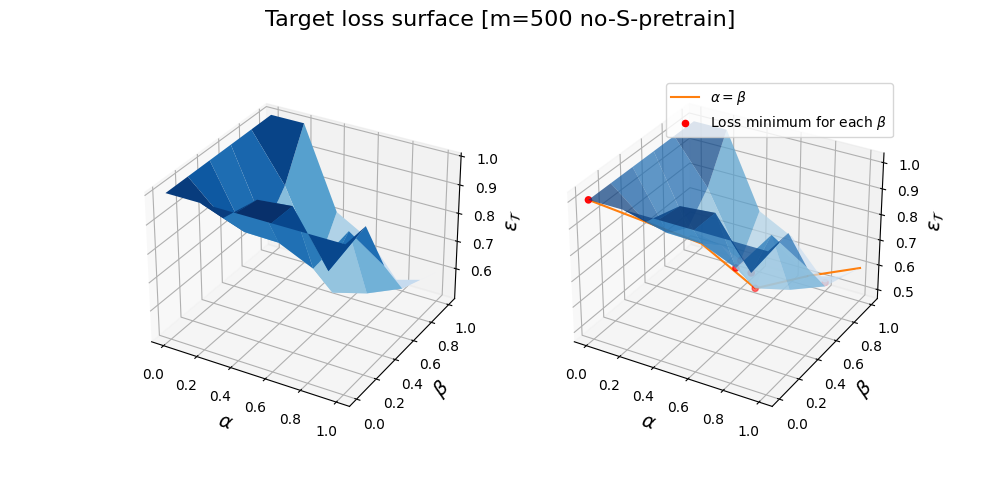

In [12]:
from matplotlib.backend_bases import MouseButton
import traceback

Z = exp3_Z.loc['loss_T'].clip(0, 1)
Z_np = Z.to_numpy()

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 5))

ax[1].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=0.7)
ax[1].plot(Z.columns, Z.index, Z.unstack().loc[list(zip(Z.columns, Z.index))], zdir='z', label=r'$\alpha=\beta$')
ax[1].scatter(Z.idxmin(1),
           Z.index,
           Z.min(1).values,
           c='red', label=r'Loss minimum for each $\beta$')

# ax.set(xticklabels=[],
#        yticklabels=[],
#        zticklabels=[])

for ax_i in ax:
    ax_i.set_xlabel(r'$\alpha$', size=14)
    ax_i.set_ylabel(r'$\beta$', size=14)
    ax_i.set_zlabel(r'$\epsilon_\mathcal{T}$', size=14)
ax[1].legend(loc=1)
# ax[1].set_title("Target loss surface")

ax[0].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=1)

error_log = []

def on_move(event):
    try:
        if event.button == MouseButton.LEFT and event.inaxes in ax:
            # Get current rotation
            curr_elev, curr_azim = event.inaxes.elev, event.inaxes.azim
            
            # Calculate the new rotation angles based on mouse movement
            # log.append(f'{event.ydata}')
            new_elev = curr_elev - event.ydata + event.lastevent.ydata
            new_azim = curr_azim - event.xdata + event.lastevent.xdata
            # log.append(f'{new_elev}, {new_azim}')

            # Update the rotation for both axes and redraw
            for ax_i in ax:
                ax_i.view_init(elev=new_elev, azim=new_azim)
                ax_i.figure.canvas.draw_idle()
    except Exception as e:
        traceback.print_exc()
        error_log.append(f'{traceback.format_exc()}')
        

cid = fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.suptitle('Target loss surface [m=500 no-S-pretrain]', fontsize=16)

# ax[0].set_zlim(Z_np.min(), 5)
plt.show()

## Experiment4: Source-trained model with $m=500$ for different $\alpha$ and $\beta$

In [13]:
from tqdm.notebook import tqdm

reset_random_seed(520)

Full_D_S_loader = FastDataLoader(D_S,  
                            weights=None,
                            batch_size=config.train.train_bs,
                            num_workers=config.num_workers)
Full_D_T_loader = FastDataLoader(D_T,  
                            weights=None,
                            batch_size=config.train.train_bs,
                            num_workers=config.num_workers)

alpha = np.arange(0, 1.1, 0.2).round(2)
beta = np.arange(0, 1.1, 0.2).clip(0.002, 0.998).round(3)
m = 500
exp4_Z = pd.concat([pd.DataFrame(index=beta, columns=alpha, dtype=float) for _ in range(4)], 
                          keys=['loss_S', 'loss_T', 'acc_S', 'acc_T'])

never_source = True
device = config.device

dh = display(exp4_Z, display_id=True)

train_pbar = tqdm(exp4_Z.loc['loss_S'].unstack(-1).index)
for al, be in train_pbar:
    model = train_new_model(alpha=al, beta=be, device=device, m=m, source_trained=True)
    test_loss_S, test_acc_S = test_on_env(model, Full_D_S_loader, device=device)
    test_loss_T, test_acc_T = test_on_env(model, Full_D_T_loader, device=device)
    
    exp4_Z.loc[(slice(None), be), al] = test_loss_S, test_loss_T, test_acc_S, test_acc_T
    train_pbar.set_description(f'Source L/A: {test_loss_S:.4f}/{test_acc_S:.4f}, Target L/A: {test_loss_T:.4f}/{test_acc_T:.4f}')
    # display(f'alpha/beta: {al}/{be}, Source L/A: {test_loss_S:.4f}/{test_acc_S:.4f}, Target L/A: {test_loss_T:.4f}/{test_acc_T:.4f}')
    dh.update(exp4_Z)
save_exp(exp4_Z, 'exp4.csv')

0.0       0.2       0.4       0.6       0.8         1.0
loss_S 0.002  0.272241  0.264312  0.507767  0.342071  0.319518  290.725471
       0.200  0.340628  0.313740  0.311541  0.391252  0.456796    1.039632
       0.400  0.397537  0.407311  0.369264  0.451874  0.459817    0.746238
       0.600  0.526284  0.426098  0.428791  0.457842  0.419218    0.702988
       0.800  0.722073  0.664220  0.477910  0.747734  0.422370    0.626354
       0.998  3.816316  2.436646  0.635402  0.675731  0.603672    0.689671
loss_T 0.002  2.588534  1.189791  1.605132  1.911610  2.056836  479.054358
       0.200  2.051050  0.807042  0.684180  0.891847  0.752556    1.077556
       0.400  1.666748  0.782751  0.745629  0.694285  0.924050    0.796084
       0.600  2.644963  0.741135  0.754792  0.664937  0.623484    0.726864
       0.800  2.446011  0.664828  0.624301  0.680530  0.538611    0.613892
       0.998  4.842978  1.565048  0.622025  0.568541  0.542001    0.641395
acc_S  0.002  0.923828  0.927246  0.882324  0.908203  0.908203    0.098145
       0.200  0.910156  0.914551  0.919922  0.901367  0.884277    0.712891
       0.400  0.898926  0.894531  0.910156  0.890625  0.890625    0.808594
       0.600  0.857910  0.897949  0.901367  0.887695  0.885742    0.821289
       0.800  0.823242  0.856934  0.883301  0.850098  0.884277    0.851074
       0.998  0.499023  0.527832  0.849609  0.829590  0.844727    0.835938
acc_T  0.002  0.604975  0.715539  0.662661  0.590915  0.630333    0.161159
       0.200  0.597044  0.793655  0.815166  0.780195  0.824660    0.732484
       0.400  0.629972  0.817931  0.820334  0.820935  0.811561    0.801827
       0.600  0.555823  0.819733  0.830309  0.845812  0.848095    0.827425
       0.800  0.567961  0.842086  0.844490  0.839442  0.858671    0.848456
       0.998  0.372792  0.703521  0.850258  0.852902  0.859392    0.845812

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

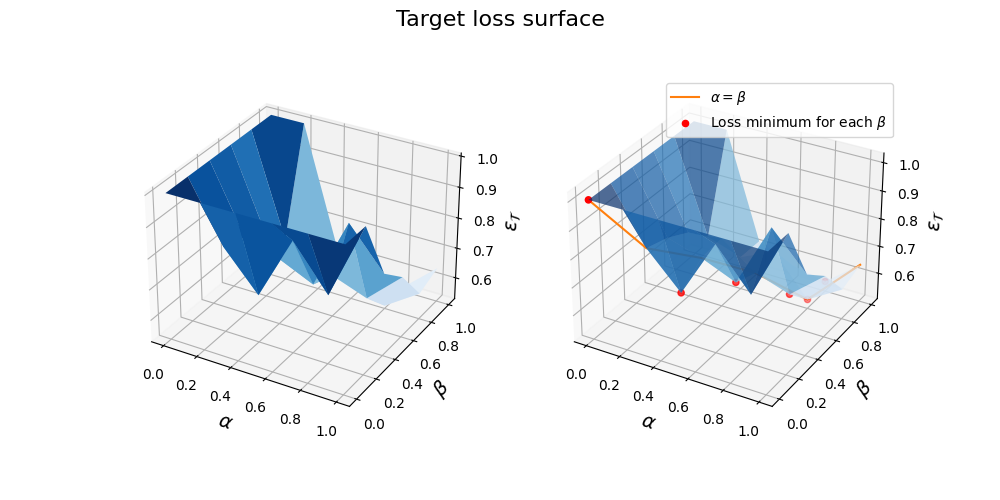

In [14]:
from matplotlib.backend_bases import MouseButton
import traceback

Z = exp4_Z.loc['loss_T'].clip(0, 1)
Z_np = Z.to_numpy()

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 5))

ax[1].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=0.7)
ax[1].plot(Z.columns, Z.index, Z.unstack().loc[list(zip(Z.columns, Z.index))], zdir='z', label=r'$\alpha=\beta$')
ax[1].scatter(Z.idxmin(1),
           Z.index,
           Z.min(1).values,
           c='red', label=r'Loss minimum for each $\beta$')

# ax.set(xticklabels=[],
#        yticklabels=[],
#        zticklabels=[])

for ax_i in ax:
    ax_i.set_xlabel(r'$\alpha$', size=14)
    ax_i.set_ylabel(r'$\beta$', size=14)
    ax_i.set_zlabel(r'$\epsilon_\mathcal{T}$', size=14)
ax[1].legend(loc=1)
# ax[1].set_title("Target loss surface")

ax[0].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=1)

error_log = []

def on_move(event):
    try:
        if event.button == MouseButton.LEFT and event.inaxes in ax:
            # Get current rotation
            curr_elev, curr_azim = event.inaxes.elev, event.inaxes.azim
            
            # Calculate the new rotation angles based on mouse movement
            # log.append(f'{event.ydata}')
            new_elev = curr_elev - event.ydata + event.lastevent.ydata
            new_azim = curr_azim - event.xdata + event.lastevent.xdata
            # log.append(f'{new_elev}, {new_azim}')

            # Update the rotation for both axes and redraw
            for ax_i in ax:
                ax_i.view_init(elev=new_elev, azim=new_azim)
                ax_i.figure.canvas.draw_idle()
    except Exception as e:
        traceback.print_exc()
        error_log.append(f'{traceback.format_exc()}')
        

cid = fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.suptitle('Target loss surface', fontsize=16)

# ax[0].set_zlim(Z_np.min(), 5)
plt.show()

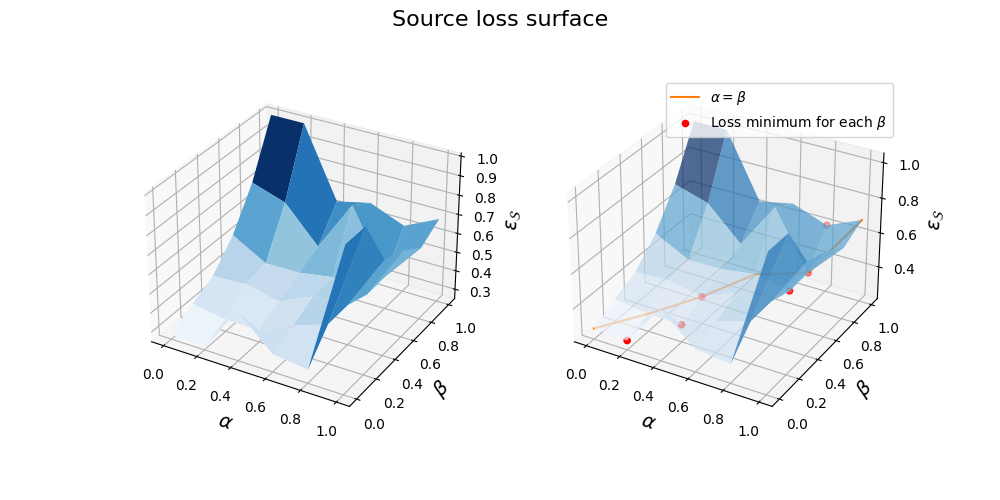

In [15]:
from matplotlib.backend_bases import MouseButton
import traceback

Z = exp4_Z.loc['loss_S'].clip(0, 1)
Z_np = Z.to_numpy()

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 5))

ax[1].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=0.7)
ax[1].plot(Z.columns, Z.index, Z.unstack().loc[list(zip(Z.columns, Z.index))], zdir='z', label=r'$\alpha=\beta$')
ax[1].scatter(Z.idxmin(1),
           Z.index,
           Z.min(1).values,
           c='red', label=r'Loss minimum for each $\beta$')

# ax.set(xticklabels=[],
#        yticklabels=[],
#        zticklabels=[])

for ax_i in ax:
    ax_i.set_xlabel(r'$\alpha$', size=14)
    ax_i.set_ylabel(r'$\beta$', size=14)
    ax_i.set_zlabel(r'$\epsilon_\mathcal{S}$', size=14)
ax[1].legend(loc=1)
# ax[1].set_title("Target loss surface")

ax[0].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=1)

error_log = []

def on_move(event):
    try:
        if event.button == MouseButton.LEFT and event.inaxes in ax:
            # Get current rotation
            curr_elev, curr_azim = event.inaxes.elev, event.inaxes.azim
            
            # Calculate the new rotation angles based on mouse movement
            # log.append(f'{event.ydata}')
            new_elev = curr_elev - event.ydata + event.lastevent.ydata
            new_azim = curr_azim - event.xdata + event.lastevent.xdata
            # log.append(f'{new_elev}, {new_azim}')

            # Update the rotation for both axes and redraw
            for ax_i in ax:
                ax_i.view_init(elev=new_elev, azim=new_azim)
                ax_i.figure.canvas.draw_idle()
    except Exception as e:
        traceback.print_exc()
        error_log.append(f'{traceback.format_exc()}')
        

cid = fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.suptitle('Source loss surface', fontsize=16)

plt.show()

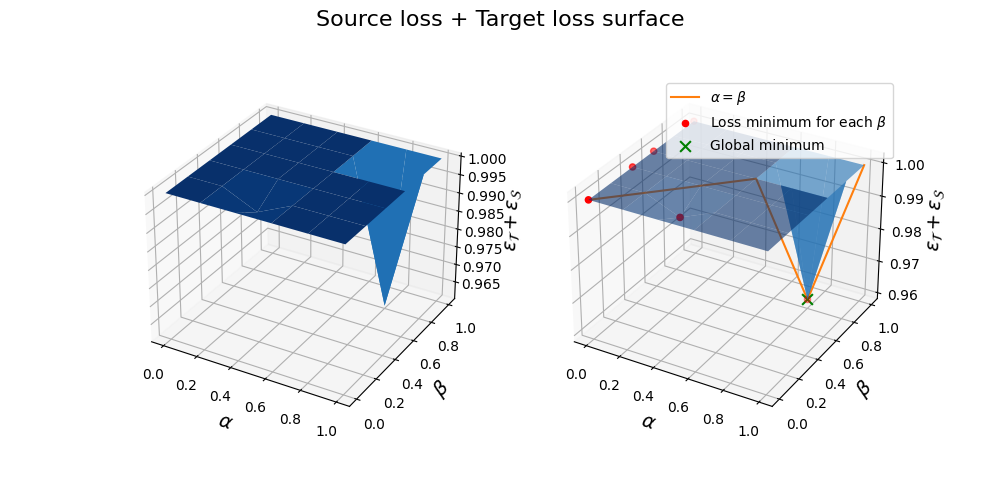

In [16]:
from matplotlib.backend_bases import MouseButton
import traceback

Z = (1 * exp4_Z.loc['loss_S'] + exp4_Z.loc['loss_T']).clip(0, 1)
Z_np = Z.to_numpy()

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 5))

ax[1].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=0.6)
ax[1].plot(Z.columns, Z.index, Z.unstack().loc[list(zip(Z.columns, Z.index))], zdir='z', label=r'$\alpha=\beta$')
ax[1].scatter(Z.idxmin(1),
           Z.index,
           Z.min(1).values,
           c='red', label=r'Loss minimum for each $\beta$')
ax[1].scatter(Z.min().idxmin(),
           Z.min(1).idxmin(),
           Z.min().min(),
              marker='x',
           c='green', s=60, label='Global minimum')

# ax.set(xticklabels=[],
#        yticklabels=[],
#        zticklabels=[])

for ax_i in ax:
    ax_i.set_xlabel(r'$\alpha$', size=14)
    ax_i.set_ylabel(r'$\beta$', size=14)
    ax_i.set_zlabel(r'$\epsilon_\mathcal{T} + \epsilon_\mathcal{S}$', size=14)
ax[1].legend(loc=1)
# ax[1].set_title("Target loss surface")

ax[0].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=1)

error_log = []

def on_move(event):
    try:
        if event.button == MouseButton.LEFT and event.inaxes in ax:
            # Get current rotation
            curr_elev, curr_azim = event.inaxes.elev, event.inaxes.azim
            
            # Calculate the new rotation angles based on mouse movement
            # log.append(f'{event.ydata}')
            new_elev = curr_elev - event.ydata + event.lastevent.ydata
            new_azim = curr_azim - event.xdata + event.lastevent.xdata
            # log.append(f'{new_elev}, {new_azim}')

            # Update the rotation for both axes and redraw
            for ax_i in ax:
                ax_i.view_init(elev=new_elev, azim=new_azim)
                ax_i.figure.canvas.draw_idle()
    except Exception as e:
        traceback.print_exc()
        error_log.append(f'{traceback.format_exc()}')
        

cid = fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.suptitle('Source loss + Target loss surface', fontsize=16)

plt.show()

## Experiment5: When m is very small, m=50 with different $\alpha$ and $\beta$

In [17]:
from tqdm.notebook import tqdm

reset_random_seed(520)

Full_D_S_loader = FastDataLoader(D_S,  
                            weights=None,
                            batch_size=config.train.train_bs,
                            num_workers=config.num_workers)
Full_D_T_loader = FastDataLoader(D_T,  
                            weights=None,
                            batch_size=config.train.train_bs,
                            num_workers=config.num_workers)

alpha = np.arange(0, 1.1, 0.2).round(2)
beta = np.arange(0, 1.1, 0.2).clip(0.02, 0.98).round(2)
m = 50
exp5_Z = pd.concat([pd.DataFrame(index=beta, columns=alpha, dtype=float) for _ in range(4)], 
                          keys=['loss_S', 'loss_T', 'acc_S', 'acc_T'])

never_source = True
device = config.device

dh = display(exp5_Z, display_id=True)

train_pbar = tqdm(exp5_Z.loc['loss_S'].unstack(-1).index)
for al, be in train_pbar:
    model = train_new_model(alpha=al, beta=be, device=device, m=m, source_trained=True)
    test_loss_S, test_acc_S = test_on_env(model, Full_D_S_loader, device=device)
    test_loss_T, test_acc_T = test_on_env(model, Full_D_T_loader, device=device)
    
    exp5_Z.loc[(slice(None), be), al] = test_loss_S, test_loss_T, test_acc_S, test_acc_T
    train_pbar.set_description(f'Source L/A: {test_loss_S:.4f}/{test_acc_S:.4f}, Target L/A: {test_loss_T:.4f}/{test_acc_T:.4f}')
    # display(f'alpha/beta: {al}/{be}, Source L/A: {test_loss_S:.4f}/{test_acc_S:.4f}, Target L/A: {test_loss_T:.4f}/{test_acc_T:.4f}')
    dh.update(exp5_Z)
save_exp(exp5_Z, 'exp5.csv')

0.0        0.2       0.4       0.6       0.8         1.0
loss_S 0.02   4.286189   1.082283  2.284041  1.356407  0.798762  290.725470
       0.20   0.798092   1.325203  0.652017  1.320413  0.856339    3.691841
       0.40   1.023200   1.598701  0.847418  1.439418  1.311392    2.636798
       0.60   6.620297   0.851115  1.172238  1.457712  1.106358    2.612116
       0.80   1.758433   1.661010  1.743589  0.973202  1.226605    2.485764
       0.98   3.816316  11.655262  2.602909  1.173366  8.886913    2.909670
loss_T 0.02  15.882250   2.564295  4.248577  2.302467  1.775215  479.054382
       0.20   1.422131   2.497674  1.480754  2.148863  1.291171    3.223728
       0.40   2.723477   1.717379  1.156705  2.335314  1.840006    1.804761
       0.60   7.761257   1.090467  1.352595  1.228997  1.534474    2.076593
       0.80   2.219022   1.352650  1.364641  1.148684  1.311579    2.430546
       0.98   4.842978   5.776658  1.788759  1.124974  4.569211    2.781863
acc_S  0.02   0.458008   0.726562  0.548340  0.707520  0.764160    0.098145
       0.20   0.760254   0.720703  0.798828  0.717285  0.759766    0.368164
       0.40   0.740234   0.679199  0.796387  0.654297  0.666016    0.423828
       0.60   0.266113   0.780273  0.722656  0.685547  0.712402    0.477051
       0.80   0.570312   0.628906  0.660156  0.735352  0.694336    0.596680
       0.98   0.499023   0.325195  0.422852  0.654785  0.235352    0.441895
acc_T  0.02   0.274967   0.477467  0.397789  0.464968  0.562553    0.161159
       0.20   0.606778   0.532628  0.629732  0.528903  0.652325    0.450547
       0.40   0.465569   0.596803  0.708449  0.524336  0.561591    0.561110
       0.60   0.199375   0.698233  0.657854  0.695589  0.628050    0.523855
       0.80   0.433482   0.661098  0.667708  0.711934  0.674198    0.579137
       0.98   0.372792   0.410047  0.585507  0.694868  0.397188    0.541041

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

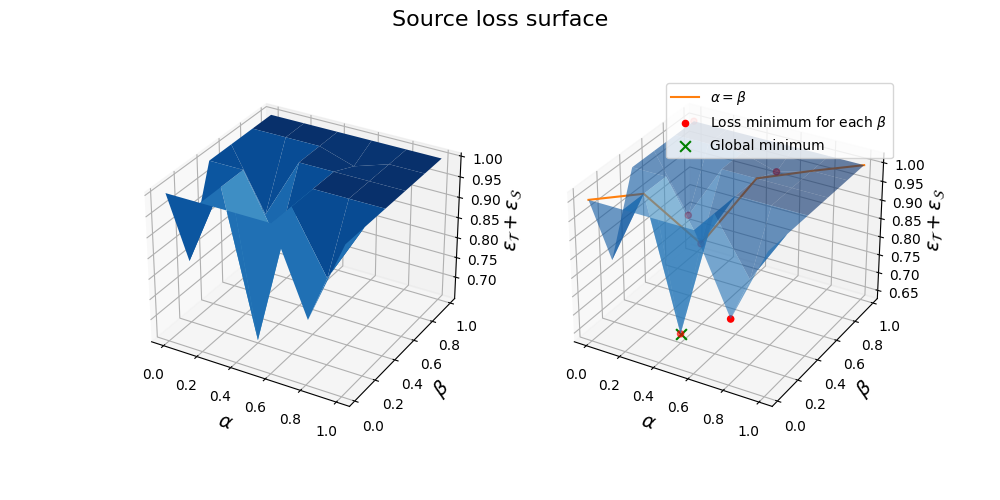

In [18]:
from matplotlib.backend_bases import MouseButton
import traceback

Z = (1 * exp5_Z.loc['loss_S'] + 0 * exp5_Z.loc['loss_T']).clip(0, 1)
Z_np = Z.to_numpy()

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 5))

ax[1].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=0.6)
ax[1].plot(Z.columns, Z.index, Z.unstack().loc[list(zip(Z.columns, Z.index))], zdir='z', label=r'$\alpha=\beta$')
ax[1].scatter(Z.idxmin(1),
           Z.index,
           Z.min(1).values,
           c='red', label=r'Loss minimum for each $\beta$')
ax[1].scatter(Z.min().idxmin(),
           Z.min(1).idxmin(),
           Z.min().min(),
              marker='x',
           c='green', s=60, label='Global minimum')

# ax.set(xticklabels=[],
#        yticklabels=[],
#        zticklabels=[])

for ax_i in ax:
    ax_i.set_xlabel(r'$\alpha$', size=14)
    ax_i.set_ylabel(r'$\beta$', size=14)
    ax_i.set_zlabel(r'$\epsilon_\mathcal{T} + \epsilon_\mathcal{S}$', size=14)
ax[1].legend(loc=1)
# ax[1].set_title("Target loss surface")

ax[0].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=1)

error_log = []

def on_move(event):
    try:
        if event.button == MouseButton.LEFT and event.inaxes in ax:
            # Get current rotation
            curr_elev, curr_azim = event.inaxes.elev, event.inaxes.azim
            
            # Calculate the new rotation angles based on mouse movement
            # log.append(f'{event.ydata}')
            new_elev = curr_elev - event.ydata + event.lastevent.ydata
            new_azim = curr_azim - event.xdata + event.lastevent.xdata
            # log.append(f'{new_elev}, {new_azim}')

            # Update the rotation for both axes and redraw
            for ax_i in ax:
                ax_i.view_init(elev=new_elev, azim=new_azim)
                ax_i.figure.canvas.draw_idle()
    except Exception as e:
        traceback.print_exc()
        error_log.append(f'{traceback.format_exc()}')
        

cid = fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.suptitle('Source loss surface', fontsize=16)

plt.show()

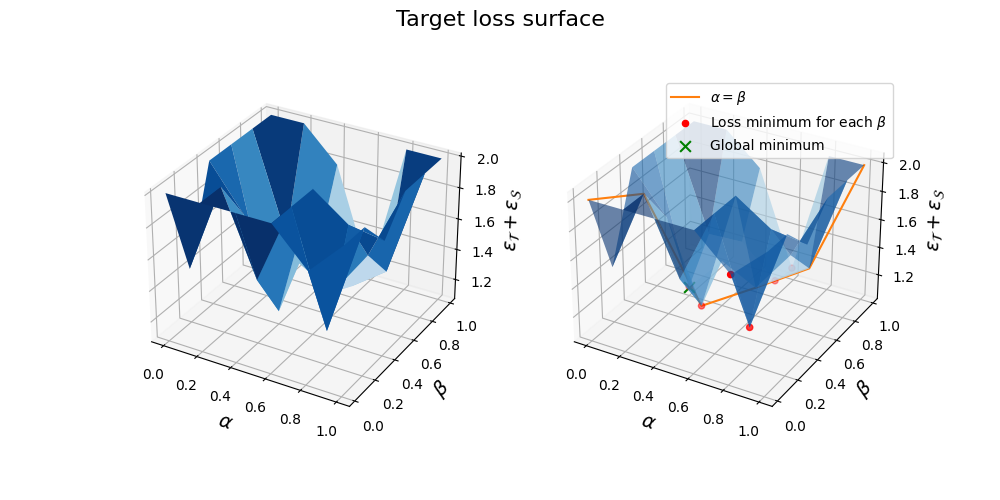

In [19]:
from matplotlib.backend_bases import MouseButton
import traceback

Z = (0 * exp5_Z.loc['loss_S'] + 1 * exp5_Z.loc['loss_T']).clip(0, 2)
Z_np = Z.to_numpy()

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 5))

ax[1].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=0.6)
ax[1].plot(Z.columns, Z.index, Z.unstack().loc[list(zip(Z.columns, Z.index))], zdir='z', label=r'$\alpha=\beta$')
ax[1].scatter(Z.idxmin(1),
           Z.index,
           Z.min(1).values,
           c='red', label=r'Loss minimum for each $\beta$')
ax[1].scatter(Z.min().idxmin(),
           Z.min(1).idxmin(),
           Z.min().min(),
              marker='x',
           c='green', s=60, label='Global minimum')

# ax.set(xticklabels=[],
#        yticklabels=[],
#        zticklabels=[])

for ax_i in ax:
    ax_i.set_xlabel(r'$\alpha$', size=14)
    ax_i.set_ylabel(r'$\beta$', size=14)
    ax_i.set_zlabel(r'$\epsilon_\mathcal{T} + \epsilon_\mathcal{S}$', size=14)
ax[1].legend(loc=1)
# ax[1].set_title("Target loss surface")

ax[0].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=1)

error_log = []

def on_move(event):
    try:
        if event.button == MouseButton.LEFT and event.inaxes in ax:
            # Get current rotation
            curr_elev, curr_azim = event.inaxes.elev, event.inaxes.azim
            
            # Calculate the new rotation angles based on mouse movement
            # log.append(f'{event.ydata}')
            new_elev = curr_elev - event.ydata + event.lastevent.ydata
            new_azim = curr_azim - event.xdata + event.lastevent.xdata
            # log.append(f'{new_elev}, {new_azim}')

            # Update the rotation for both axes and redraw
            for ax_i in ax:
                ax_i.view_init(elev=new_elev, azim=new_azim)
                ax_i.figure.canvas.draw_idle()
    except Exception as e:
        traceback.print_exc()
        error_log.append(f'{traceback.format_exc()}')
        

cid = fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.suptitle('Target loss surface', fontsize=16)

plt.show()

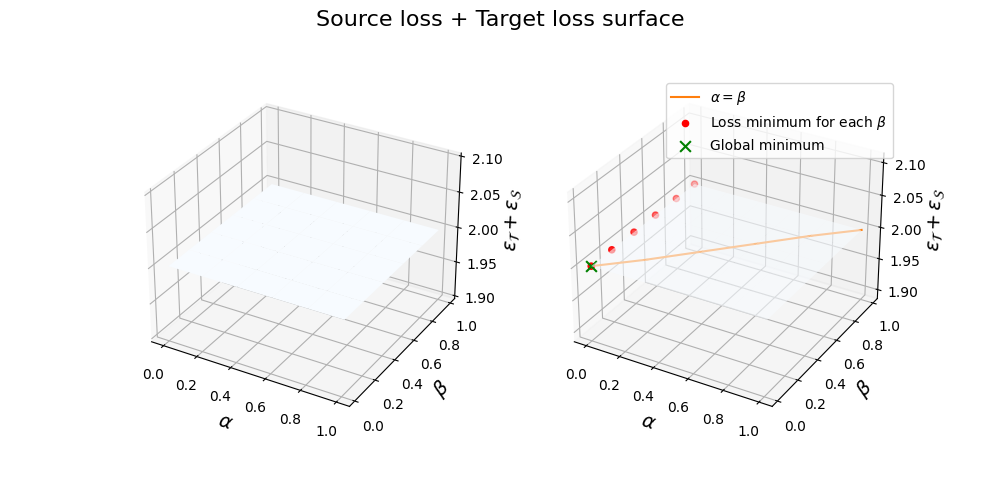

In [20]:
from matplotlib.backend_bases import MouseButton
import traceback

Z = (2 * exp5_Z.loc['loss_S'] + 1 * exp5_Z.loc['loss_T']).clip(0, 2)
Z_np = Z.to_numpy()

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 5))

ax[1].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=0.6)
ax[1].plot(Z.columns, Z.index, Z.unstack().loc[list(zip(Z.columns, Z.index))], zdir='z', label=r'$\alpha=\beta$')
ax[1].scatter(Z.idxmin(1),
           Z.index,
           Z.min(1).values,
           c='red', label=r'Loss minimum for each $\beta$')
ax[1].scatter(Z.min().idxmin(),
           Z.min(1).idxmin(),
           Z.min().min(),
              marker='x',
           c='green', s=60, label='Global minimum')

# ax.set(xticklabels=[],
#        yticklabels=[],
#        zticklabels=[])

for ax_i in ax:
    ax_i.set_xlabel(r'$\alpha$', size=14)
    ax_i.set_ylabel(r'$\beta$', size=14)
    ax_i.set_zlabel(r'$\epsilon_\mathcal{T} + \epsilon_\mathcal{S}$', size=14)
ax[1].legend(loc=1)
# ax[1].set_title("Target loss surface")

ax[0].plot_surface(*np.meshgrid(Z.columns, Z.index), Z_np, vmin=Z_np.min(), cmap=cm.Blues, alpha=1)

error_log = []

def on_move(event):
    try:
        if event.button == MouseButton.LEFT and event.inaxes in ax:
            # Get current rotation
            curr_elev, curr_azim = event.inaxes.elev, event.inaxes.azim
            
            # Calculate the new rotation angles based on mouse movement
            # log.append(f'{event.ydata}')
            new_elev = curr_elev - event.ydata + event.lastevent.ydata
            new_azim = curr_azim - event.xdata + event.lastevent.xdata
            # log.append(f'{new_elev}, {new_azim}')

            # Update the rotation for both axes and redraw
            for ax_i in ax:
                ax_i.view_init(elev=new_elev, azim=new_azim)
                ax_i.figure.canvas.draw_idle()
    except Exception as e:
        traceback.print_exc()
        error_log.append(f'{traceback.format_exc()}')
        

cid = fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.suptitle('Source loss + Target loss surface', fontsize=16)

plt.show()

## Fix $m_T$, increase $m_S$, how $\epsilon_T$ changes

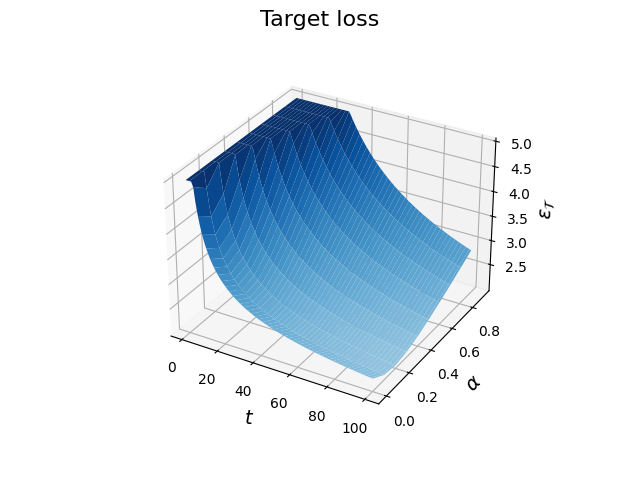

In [21]:
t = np.arange(1, 101)
mt = t * 2 #+ 10
d = 50
delta = 1e-2

ms = t * 30 #+ 50
m = ms + mt
alpha = np.arange(0, 1, 1e-1)
t, alpha = np.meshgrid(t, alpha)
beta = mt / m

# * np.log(2 * m + 2)
Z = 4 * np.sqrt((alpha **2) / beta + ((1-alpha) ** 2) / (1 - beta)) * np.sqrt((2 * d  + 2 * np.log(8/delta))/ m) + 2 * (1 - alpha) * 0.715
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(t, alpha, Z.clip(2, 5), vmin=0, cmap=cm.Blues, alpha=1)
ax.set_xlabel(r'$t$', size=14)
ax.set_ylabel(r'$\alpha$', size=14)
ax.set_zlabel(r'$\epsilon_\mathcal{T}$', size=14)

fig.suptitle('Target loss', fontsize=16)

plt.show()

In [22]:
beta

array([0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625])